In [5]:
import numpy as np
from numpy import sin,cos,tan
from math import pi
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [124]:
conv = 2*pi/360
A = 2
s = 4
h = 2

def ratio(alp,bet,psi,S):
    bet,alp,psi = conv*bet,conv*alp,conv*psi
    
    xb = -0.5*A*cos(bet) + S
    yb = -0.5*A*sin(bet) + h
    B = [xb,yb]
    
    xp = (0.5*A*(sin(alp) + cos(alp)*tan(psi)) + S*tan(bet))/(tan(bet) + tan(psi))
    yp = tan(bet)*(xp - S) + h
    P = [xp ,yp]
    
    d = np.sqrt((P[0] - B[0])**2 + (P[1] - B[1])**2)
    
    if (P[0] >= B[0]) and (d < A):
        S = 1 - d/A
    elif (P[0] >= B[0]) and (d >= A):
        S = 0
    elif (P[0] < B[0]):    
        S = 1
    return S

def potencia0(alp0,psi):
    P = A*sin(pi - conv*psi  - conv*alp0)
    return P

def potencia(alp1,alp0,psi,N):
    P = A*ratio(alp0,alp1,psi,N)*sin(pi - conv*psi  - conv*alp1)
    return P

def potencia_rat(S,alp,psi):
    P = A*S*sin(pi - conv*psi  - conv*alp)
    return P

In [139]:
alp = [5,10,15,20,30,45]
psi = 5

potencias = []
alpha = []
for a1 in range(0,45,10):
    for a2 in range(0,45,10):
        for a3 in range(0,45,10):
            for a4 in range(0,45,10):
                for a5 in range(0,45,10):
                    for a6 in range(0,45,10):
                        alp = [a1,a2,a3,a4,a5,a6]
                        I,J = [0],[0]
                        S = [1]

                        for i in range(len(alp)-1):
                            for j in range(i+1,len(alp)):
                                S.append(ratio(alp[i],alp[j],psi,(j-i)*s))
                                I.append(i)
                                J.append(j)
                        ratios = pd.DataFrame({'i':I,'j':J,'S':S})
                        jun = np.unique(ratios.j)
                        rt = []
                        for j in jun:
                            rt.append(np.min(ratios[ratios.j == j].S))
                        P = 0
                        for i in range(len(alp)):
                            P += potencia_rat(rt[i],alp[i],psi)
                        potencias.append(P)
                        alpha.append(alp)

In [162]:
alp = alpha[np.where(potencias == np.max(potencias))[0][0]]

In [161]:
alp

[40, 40, 20, 40, 40, 40]

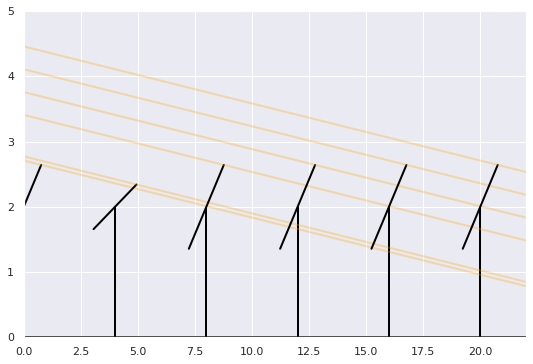

In [154]:
plt.figure(figsize = (9,6))
plt.axhline(y=0, color='black', linestyle='-')

for i in range(len(alp)):
    plot_placa_(alp[i],i,psi)
plt.ylim([0,5])
plt.xlim([0,A + (len(alp)-1)*s])
plt.show()

In [12]:
def plot_placa_(alpha,N,phi):
    alpha = alpha*conv
    phi = phi*conv
    plt.vlines(x=N*s, ymin=0, ymax=h, linewidth=2, color='black')
    
    x = np.linspace(-0.5*A*cos(alpha),0.5*A*cos(alpha),100)     
    y_ = tan(alpha)*x + h
    
    plt.plot(x+N*s,y_, linewidth=2, color='black')
    
    x_ = np.linspace(-100,100,100)
    
    plt.plot(x_ + N*s ,
             -tan(phi)*x_ + y_[-1] + tan(phi)*x[-1],
             linewidth=2, 
             color='orange',alpha = 0.3)

In [192]:

alp = [45,45,45,45,45,45]
psi = 45

def coste(alp):
    I,J = [0],[0]
    S = [1]

    for i in range(len(alp)-1):
        for j in range(i+1,len(alp)):
            S.append(ratio(alp[i],alp[j],psi,(j-i)*s))
            I.append(i)
            J.append(j)
            
    ratios = pd.DataFrame({'i':I,'j':J,'S':S})
    jun = np.unique(ratios.j)
    
    rt = []
    for j in jun:
        rt.append(np.min(ratios[ratios.j == j].S))
    
    P = 0
    for i in range(len(alp)):
        P += potencia_rat(rt[i],alp[i],psi)
    return -P
    # return [-P,S]

In [193]:
from pymoo.algorithms.soo.nonconvex.ga import GA

from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga2 import SimulatedBinaryCrossover
from pymoo.algorithms.moo.nsga2 import PolynomialMutation
from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation

In [205]:
n_placas = 5
psi = 15
xl = np.repeat(0,n_placas)
xu = np.repeat(80,n_placas)

problem = FunctionalProblem(n_placas,coste,xl=xl,xu=xu)


algorithm = GA(pop_size=100,
                  sampling=get_sampling('real_random'),
                  crossover=get_crossover("real_sbx", prob=0.9, eta=20),
                  mutation=get_mutation("real_pm", eta=10, prob=1.0),
                  eliminate_duplicates=True)

termination = MultiObjectiveSpaceToleranceTermination(tol=0.05,
                                                      n_last=100,
                                                      nth_gen=5,
                                                      n_max_gen=1e14,
                                                      n_max_evals=None)

res = minimize(problem,
               algorithm,
               termination=termination,
               seed=123,
               save_history=False)

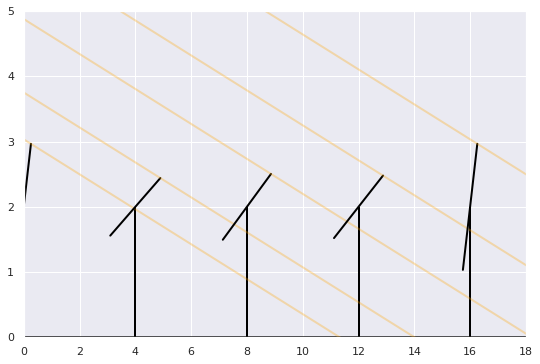

In [207]:
alp = res.X
plt.figure(figsize = (9,6))
plt.axhline(y=0, color='black', linestyle='-')

for i in range(len(alp)):
    plot_placa_(alp[i],i,psi)
plt.ylim([0,5])
plt.xlim([0,A + (len(alp)-1)*s])
plt.show()